## Import library

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import cv2
import os
import random ##用于随机生成class的index
from sklearn.utils import shuffle
from sklearn.svm import SVC
import time
import csv
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from ensurepip import bootstrap
from sklearn.ensemble import RandomForestClassifier

In [2]:
## check for python version
from platform import python_version
print(f'the version of python is:', python_version())

the version of python is: 3.9.13


## Check the basic information of the dataset

#### the preprocessing part have the source, mostly generate the idea of what to do 
#### F. ROBERT, (2022, Jul), "ffi-font-etl-and-classify". Available: https://www.kaggle.com/code/frobert/ffi-font-etl-and-classify

(50, 50, 3)
(50, 150, 3)


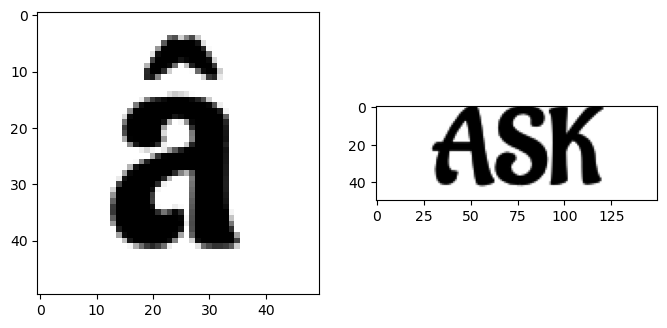

In [3]:
## check for imgs with differnt size -> 50 * 50 ， 150 * 50
img_1 = cv2.imread('font_data/Aladin-Regular/Aladin-Regular$$U00c3U00a2.00000.png')
img_2 = cv2.imread('font_data/Aladin-Regular/Aladin-Regular$$U0041U0053U004b.00000.png')

print(img_1.shape)
print(img_2.shape)

plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.subplot(121)
plt.imshow(img_1)
plt.subplot(122)
plt.imshow(img_2)

In [4]:
## gain all tha classes and their numbers

dir_path = "font_data"
class_list = os.listdir(dir_path)
class_list.remove('.DS_Store')
file_paths = []
labels = []

for classes in class_list:
    class_path = os.path.join(dir_path, classes)
    for _ in class_path.split('\n'):
        i = 0 ## the number for different pics in different classes
        for l in os.listdir(_):
            file_path = os.path.join(_,l)
            img = Image.open(file_path)
            img.convert('1')
            file_paths.append(file_path)
            labels.append(classes)
            i = i+1
        ## print(f'There are {i} data in {_} class') -> how many samples in a class
File_col = pd.Series(file_paths, name='files')
Label_col = pd.Series(labels, name='labels')
data = pd.concat([File_col, Label_col], axis=1)

In [5]:
print(f'the tol number of classes in this datasets are:', len(class_list))
print(f'there are total {len(data)} data in dataset')
# print(f'the classes in this dataset are: ', class_list)
# print(f'for each class here, the numbers are: \n', data.labels.value_counts())

the tol number of classes in this datasets are: 35
there are total 11760 data in dataset


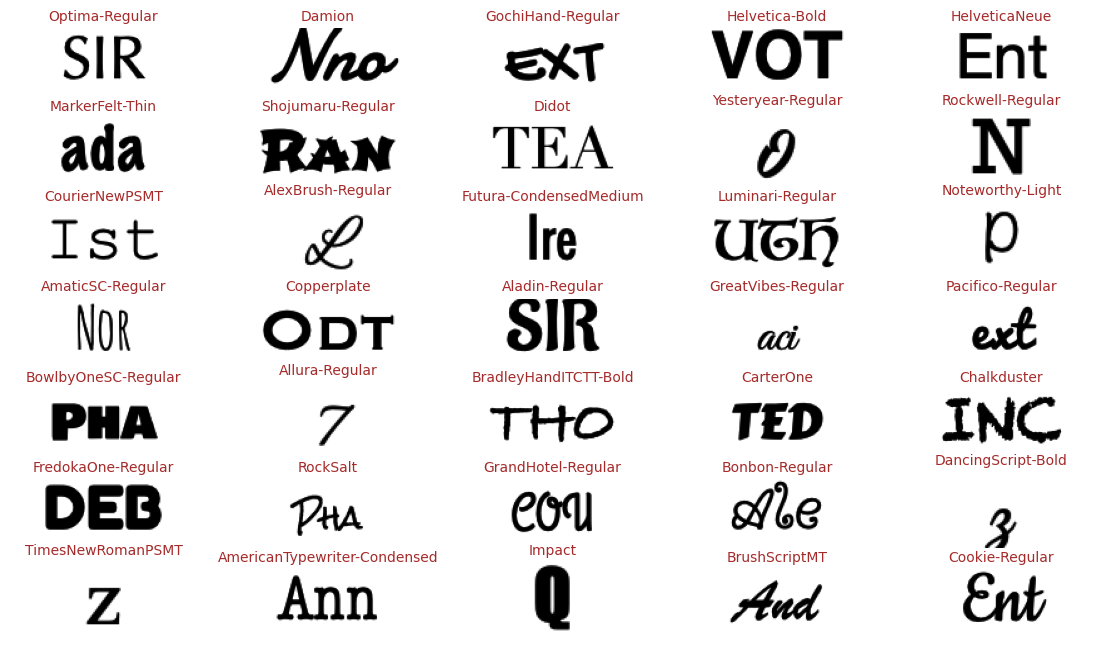

In [6]:
## print one image in each class
out = data.drop_duplicates('labels')
img_path = out["files"].tolist()
label = data.loc[out.index]['labels'].tolist()
plt.rcParams['figure.figsize'] = (14.0,8.0)

for i in range(35):
    plt.subplot(7, 5, i+1)
    img = cv2.imread(img_path[i])
    plt.imshow(img)
    class_name = label[i]
    plt.title(class_name, color='brown', fontsize=10)
    plt.axis('off')
plt.show()

## Data preprocessing

In [7]:
## label all the fonts with different image ids
label2id = {}
for i, label in enumerate(class_list):
    label2id[label] = i
print(label2id)

data['labels'] = data['labels'].replace(label2id)

{'Optima-Regular': 0, 'Damion': 1, 'GochiHand-Regular': 2, 'Helvetica-Bold': 3, 'HelveticaNeue': 4, 'MarkerFelt-Thin': 5, 'Shojumaru-Regular': 6, 'Didot': 7, 'Yesteryear-Regular': 8, 'Rockwell-Regular': 9, 'CourierNewPSMT': 10, 'AlexBrush-Regular': 11, 'Futura-CondensedMedium': 12, 'Luminari-Regular': 13, 'Noteworthy-Light': 14, 'AmaticSC-Regular': 15, 'Copperplate': 16, 'Aladin-Regular': 17, 'GreatVibes-Regular': 18, 'Pacifico-Regular': 19, 'BowlbyOneSC-Regular': 20, 'Allura-Regular': 21, 'BradleyHandITCTT-Bold': 22, 'CarterOne': 23, 'Chalkduster': 24, 'FredokaOne-Regular': 25, 'RockSalt': 26, 'GrandHotel-Regular': 27, 'Bonbon-Regular': 28, 'DancingScript-Bold': 29, 'TimesNewRomanPSMT': 30, 'AmericanTypewriter-Condensed': 31, 'Impact': 32, 'BrushScriptMT': 33, 'Cookie-Regular': 34}


In [8]:
data ## check what is store in dataframe

,files,labels
0,font_data/Optima-Regular/Optima-Regular$$U0053...,0
1,font_data/Optima-Regular/Optima-Regular$$U0039...,0
2,font_data/Optima-Regular/Optima-Regular$$U0043...,0
3,font_data/Optima-Regular/Optima-Regular$$U0050...,0
4,font_data/Optima-Regular/Optima-Regular$$U0043...,0
...,...,...
11755,font_data/Cookie-Regular/Cookie-Regular$$U0048...,34
11756,font_data/Cookie-Regular/Cookie-Regular$$U0043...,34
11757,font_data/Cookie-Regular/Cookie-Regular$$U0066...,34
11758,font_data/Cookie-Regular/Cookie-Regular$$U0050...,34


## 1. data preprocessing 
###### 1st step: Remove the blank part of the picture so that there are only letters left in the picture
###### 2nd step: Segment the image of size of (150 * 50) into 3 parts
###### 3nd step: resize the image into (40 * 40)

## 2. feature selection: Edge detection using canny method

In [ ]:
## find where the pixel of the text starts
## classify the img according to their size
def get_exact_pic(img):
    dts = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ## dilated
    kernel_1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dts = cv2.erode(dts.copy(), kernel_1)
    dts = cv2.dilate(dts.copy(), kernel_1)
    dts = cv2.Canny(dts,40,255)
    

    mask = dts[:,:] != 0
    coordinate = np.argwhere(mask) 
    y_min, x_min = coordinate.min(axis = 0)
    y_max, x_max = coordinate.max(axis = 0) + 1
    
    x_diff = x_max - x_min

    if dts.shape == (50,50):
        region_sin = dts[y_min:y_max, x_min:x_max]
        region_sin = cv2.resize(region_sin, (40,40), interpolation=cv2.INTER_NEAREST)
        region = region_sin
    else:
        for i in range(1,4):
            if i==1:
                region_1 = dts[y_min:y_max, x_min: x_min+int(x_diff/3)]
                region_1  = cv2.resize(region_1, (40,40), interpolation=cv2.INTER_NEAREST)
            if i==2:
                region_2 = dts[y_min:y_max, x_min+int(x_diff/3):x_min+2*int(x_diff/3)]
                region_2  = cv2.resize(region_2, (40,40), interpolation=cv2.INTER_NEAREST)
            if i==3:
                region_3 = dts[y_min:y_max, x_min+2*int(x_diff/3):x_max]
                region_3  = cv2.resize(region_3, (40,40), interpolation=cv2.INTER_NEAREST)
        region = [region_1, region_2, region_3]
        
    return region


In [34]:
## splite the image 50 from image 150

i = 0 ## to calculate the number of (50*50) image
j = 0 ## to calculate the number of (50*150) image
label_150 = []
img_resize = []
label_resize = []
img_paths_list = data['files'].tolist()

for _ in range(len(data)):
    path = img_paths_list[_]
    img = cv2.imread(path)
    new_dir = 'noname'
    img_path_50 = os.path.join(new_dir, 'img_50')
    img_path_150 = os.path.join(new_dir, 'img_150')
    if img.shape == (50,50,3):
        img = get_exact_pic(img)
        label_ = data.loc[data['files']==path]['labels'].tolist()[0]
        label_resize.append(label_)
        img_resize.append(os.path.join(img_path_50, f'{str(i)}.png'))
        if os.path.exists(img_path_50) == False:
            os.makedirs(img_path_50)
            cv2.imwrite(os.path.join(img_path_50, f'{str(i)}.png'),img)
        else:
            cv2.imwrite(os.path.join(img_path_50, f'{str(i)}.png'),img)
        i = i+1

    else: 
        result_list = get_exact_pic(img)
        label_1 = data.loc[data['files']==path]['labels'].tolist()[0]
        for k in range(3):
            img_resize.append(os.path.join(img_path_150, f'{str(j)}.png'))
            label_resize.append(label_1)
            if os.path.exists(img_path_150) == False:
                os.makedirs(img_path_150)
                cv2.imwrite(os.path.join(img_path_150, f'{str(j)}.png'),result_list[k])
            else:
                cv2.imwrite(os.path.join(img_path_150, f'{str(j)}.png'),result_list[k])
            j = j+1
print(f'there are {i} pics in 50*50 files')
print(f'There are {j} pics in 150*50 files, which splited into 50*50')
print(f'After resizing, there are totally {len(label_resize)} number of data')

there are 3010 pics in 50*50 files
There are 26250 pics in 150*50 files, which splited into 50*50
After resizing, there are totally 29260 number of data


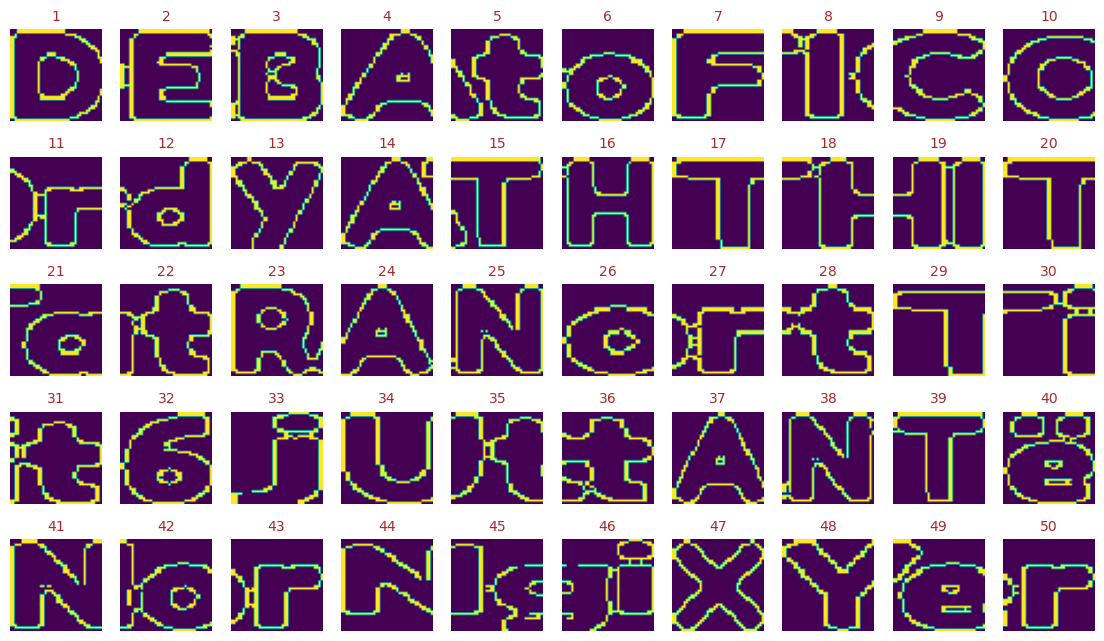

In [41]:
class_index = random.randint(0,34)
label_index = label_resize.index(class_index)
img = img_resize[label_index:label_index+50]
for i in range(50):
    img_ = Image.open(img[i])
    plt.subplot(5, 10, i+1)
    plt.imshow(img_)
    plt.title(i+1, color='brown', fontsize=10)
    plt.axis('off')
plt.show()

## load the data and prepare for training

In [43]:
# for path in range(len(img_resize)):
#     img = cv2.imread(img_resize[path])
#     img = img.flatten()/255
i = 0
pixel_list = []
col_name = []
for i in range(40*40):
    col_name.append(f'pixel{i}')
col_name.append('label')
with open('test_1.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(col_name)
    # writer.writerow(['label'])

    for path in range(len(img_resize)):
        img_data = []
        img = cv2.imread(img_resize[path])
        img = img[:,:,0]
        img_pixel = (img.flatten()/255).tolist()
        for i in range(len(img_pixel)):
            img_data.append(img_pixel[i])
        # print(img_data)
        img_data.append(label_resize[path])
        row = [img_data]
        writer.writerows(row)

## if we dont have any feature extration or selection action, check the acc

In [ ]:
## when we do not drop any features, the accuracy is:
df = pd.read_csv('test.csv')
df = shuffle(df)

label_value = df['label']
pixel_value = df.iloc[:,0:-1]

x_train, x_test, y_train, y_test = train_test_split(pixel_value, label_value, train_size = 0.8,random_state=42)

model = SVC(kernel='rbf')
model.fit(x_train, y_train)
print(f'test acc:', model.score(x_test, y_test))

test acc: 0.7241968557758032


## feature selection and extraction method 1: demension reduction by PCA

In [45]:
## If use PCA method to test for its accuracy
PCA_value = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
PCA_acc = []

for i in range(len(PCA_value)):
    label_value = df['label']
    pixel_value = df.iloc[:,0:-1]

    pca = PCA(n_components=PCA_value[i])
    pixel_value = pca.fit_transform(pixel_value)
    x_train, x_test, y_train, y_test = train_test_split(pixel_value, label_value, train_size = 0.8,random_state=42)
    model = SVC(kernel='rbf')
    model.fit(x_train, y_train)

    score = model.score(x_test, y_test)
    print(score)

    PCA_acc.append(score)

0.7582023239917977
0.7684552289815447
0.7665755297334245
0.7611073137388927
0.754272043745728
0.7481203007518797
0.74419002050581
0.7395762132604238
0.7353041695146958
0.732740943267259


When PCA n_component is 200, it can reach acc of 0.7684552289815447


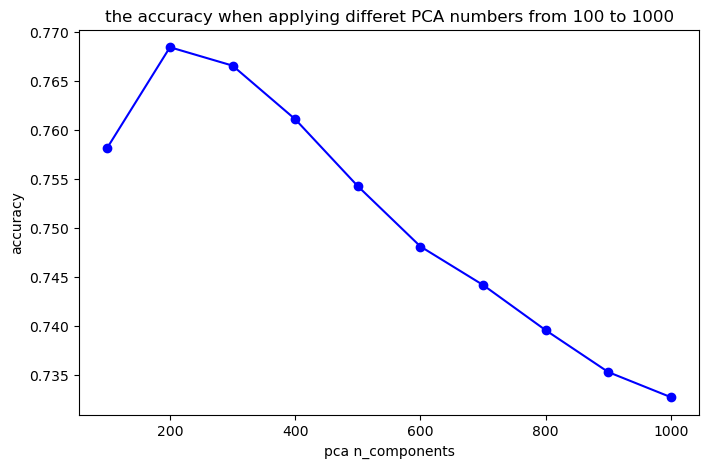

In [46]:
print(f'When PCA n_component is {PCA_value[PCA_acc.index(max(PCA_acc))]}, it can reach acc of {max(PCA_acc)}')

plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.title('the accuracy when applying differet PCA numbers from 100 to 1000')
plt.xlabel('pca n_components')
plt.ylabel('accuracy')
plt.plot(PCA_value, PCA_acc, marker='o', color='b')

In [47]:
## conclusion: round p = 200 got higest acc
## use more accurate number of compoents to test for the acc

PCA_value = np.arange(160,300,10)
PCA_acc_1 = []

for i in range(len(PCA_value)):
    label_value = df['label']
    pixel_value = df.iloc[:,0:-1]

    pca = PCA(n_components=PCA_value[i])
    pixel_value = pca.fit_transform(pixel_value)
    x_train, x_test, y_train, y_test = train_test_split(pixel_value, label_value, train_size = 0.8,random_state=42)
    model = SVC(kernel='rbf')
    model.fit(x_train, y_train)

    score = model.score(x_test, y_test)
    print(score)

    PCA_acc_1.append(score)

0.7667464114832536
0.7669172932330827
0.7653793574846206
0.7701640464798359
0.7655502392344498
0.7718728639781272
0.7698222829801777
0.7694805194805194
0.7682843472317157
0.7682843472317157
0.7679425837320574
0.7664046479835953
0.7698222829801777
0.768796992481203


When PCA n_component is 210, it can reach acc of 0.7718728639781272


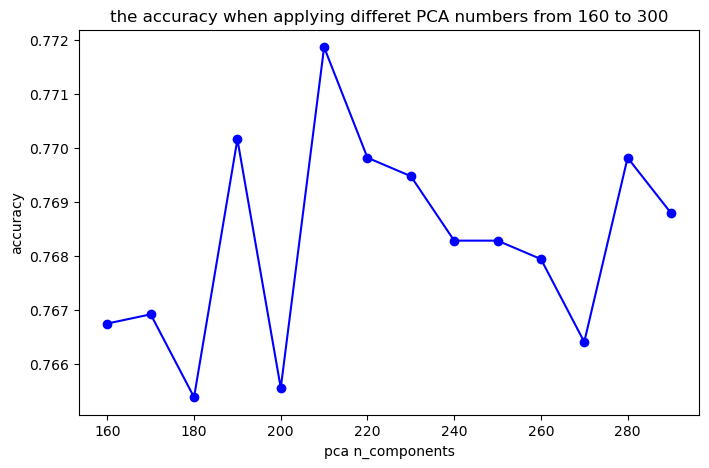

In [48]:
print(f'When PCA n_component is {PCA_value[PCA_acc_1.index(max(PCA_acc_1))]}, it can reach acc of {max(PCA_acc_1)}')

plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.title('the accuracy when applying differet PCA numbers from 160 to 300')
plt.xlabel('pca n_components')
plt.ylabel('accuracy')
plt.plot(PCA_value, PCA_acc_1, marker='o', color='b')

## feature selection and feature extraction method 2: dimension reduction by Decision Tree

In [49]:
label_value = df['label']
pixel_value = df.iloc[:,0:-1]

x_train, x_test, y_train, y_test = train_test_split(pixel_value, label_value, train_size = 0.8, random_state=42)

In [50]:
x_train.shape

(23408, 1600)

In [51]:
## check the feature impoetance with Rf
rfc_model = RandomForestClassifier(random_state=100, bootstrap=False)
rfc_model.fit(x_train, y_train)
print(f'the acc of model is:', rfc_model.score(x_test, y_test))

importances = rfc_model.feature_importances_
print(f'importance of model features:', importances)

the acc of model is: 0.7337662337662337
importance of model features: [0.00052002 0.00065171 0.00061935 ... 0.00071618 0.00070128 0.00057055]


the maximum importance 0.0012476365784276995
the minimum importance 0.00041506577716588


Text(0, 0.5, 'feature importance')

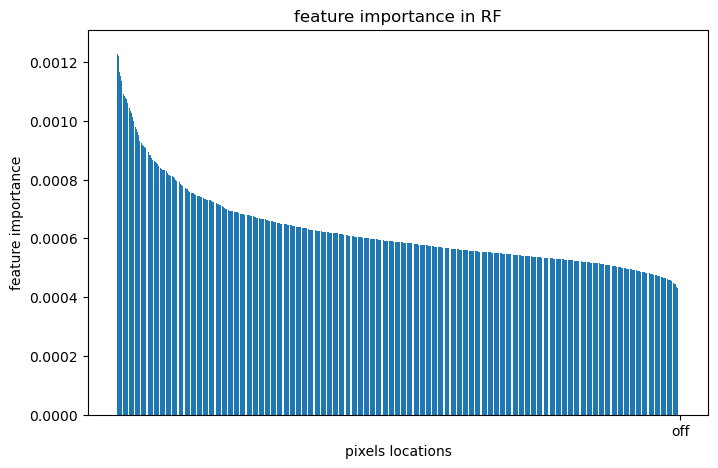

In [52]:
print(f'the maximum importance {max(importances)}')
print(f'the minimum importance {min(importances)}')

indices = np.argsort(importances)[::-1]

names = [col_name[i] for i in indices]
importance_ = [importances[i] for i in indices]

plt.title('feature importance in RF')
plt.bar(names, importance_, align='center')
plt.xticks('off')
plt.xlabel('pixels locations')
plt.ylabel('feature importance')

In [53]:
num = sum(i<0.00055 for i in importances)
print(f'there are {num} less important features')
indices = indices[0:(1600-num)]
names = [col_name[i] for i in indices]
x_train = x_train[names]
x_test = x_test[names]

there are 521 less important features


In [54]:
model = SVC(kernel='rbf')
model.fit(x_train, y_train)
print(f'test acc:', model.score(x_test, y_test))

test acc: 0.7086466165413534


## train the model

In [56]:
## Use PCA method with n=210
label_value = df['label']
pixel_value = df.iloc[:,0:-1]

pca = PCA(n_components=210)
pixel_value = pca.fit_transform(pixel_value)

x_train, x_test, y_train, y_test = train_test_split(pixel_value, label_value, train_size = 0.8, random_state=42)

In [72]:
gammas = np.logspace(-3, 0, 4)
cs = np.logspace(-3, 0, 4)
degrees = [1,2,3,4]
linear_score = []
best_score = 0


for c in cs:
    model = SVC(kernel='linear', C=c)
    model.fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv=4).mean()
    print(f'Test on C:{c}, with validation accuracy:{score}')

    if score > best_score:
        best_score = score
        best_c = c

    linear_score.append(score)

print(f'the best c is {best_c}, and the according best validation accuracy is:{best_score}')

Test on C:0.001, with validation accuracy:0.4806476418318524
Test on C:0.01, with validation accuracy:0.5695061517429938
Test on C:0.1, with validation accuracy:0.5597658920027342
Test on C:1.0, with validation accuracy:0.5313995215311005
the best c is 0.01, and the according best validation accuracy is:0.5695061517429938


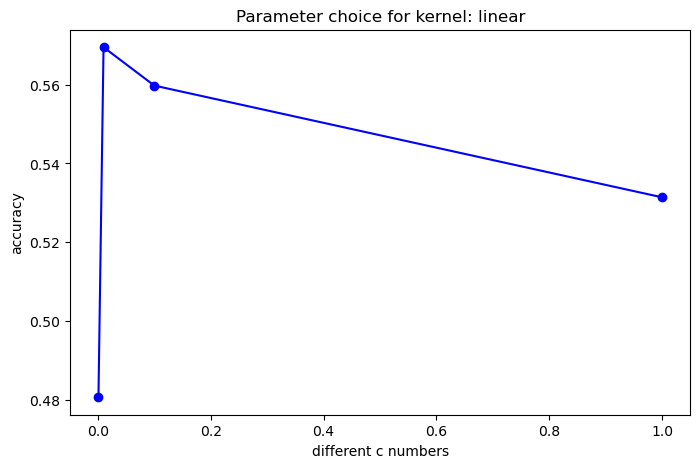

In [73]:
plt.plot(cs, linear_score, marker='o', color='b')
plt.xlabel('different c numbers')
plt.ylabel('accuracy')
plt.title('Parameter choice for kernel: linear')
plt.show()

In [78]:
rbf_score = []
rbf_train_acc = []
best_score_1 = 0.0


for _ in gammas:
   for i in cs:
      model_1 = SVC(kernel='rbf', C=i, gamma=_)
      model_1.fit(x_train, y_train)
      train_acc = model_1.score(x_train, y_train)
      score_1 = cross_val_score(model_1, x_train, y_train, cv=4).mean()
      print(f'Test on c:{i} and gamma:{_}, with validation accuracy:{score_1}')

      if score_1 > best_score_1:
         best_score_1 = score_1
         best_gamma_1 = _
         best_c_1 = i   

      rbf_train_acc.append(train_acc)
      rbf_score.append(score_1)

Test on c:0.001 and gamma:0.001, with validation accuracy:0.029690704032809295
Test on c:0.01 and gamma:0.001, with validation accuracy:0.029690704032809295
Test on c:0.1 and gamma:0.001, with validation accuracy:0.2530758714969241
Test on c:1.0 and gamma:0.001, with validation accuracy:0.5564336978810663
Test on c:0.001 and gamma:0.01, with validation accuracy:0.029690704032809295
Test on c:0.01 and gamma:0.01, with validation accuracy:0.029690704032809295
Test on c:0.1 and gamma:0.01, with validation accuracy:0.4354494190020506
Test on c:1.0 and gamma:0.01, with validation accuracy:0.7556818181818181
Test on c:0.001 and gamma:0.1, with validation accuracy:0.029690704032809295
Test on c:0.01 and gamma:0.1, with validation accuracy:0.029690704032809295
Test on c:0.1 and gamma:0.1, with validation accuracy:0.029690704032809295
Test on c:1.0 and gamma:0.1, with validation accuracy:0.26670369104579633
Test on c:0.001 and gamma:1.0, with validation accuracy:0.029690704032809295
Test on c:0

In [81]:
def plot_img(data):
    posX = [i for i in range(len(cs))]
    posY = [i for i in range(len(gammas))]

    labels_X = cs[posX]
    labels_Y = gammas[posY]
    # labels_X = [int(gammas[i]) for i in range(len(labels_X))]
    # labels_Y = [int(labels_Y[i]) for i in range(len(labels_Y))]

    fig, ax = plt.subplots()
    ax.set_xticks(posX)
    ax.set_xticklabels(labels_X)
    ax.set_yticks(posY)
    ax.set_yticklabels(labels_Y)
    ax.set_xlabel('Different try on Cs')
    ax.set_ylabel('Different try on gammas')
    # plt.imshow(np.array(data).reshape(4,4))
    plt.imshow(np.array(data).reshape(4,4)) #simply for better visualization
    plt.colorbar()

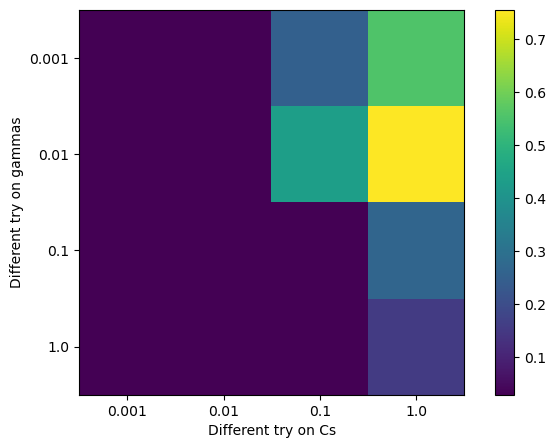

In [82]:
plot_img(rbf_score)

In [84]:
poly_score = []
poly_train_acc = []
best_score_2 = 0.0

for c in cs: 
    for _ in gammas:
        for i in degrees:
            model_2 = SVC(kernel='poly', gamma=_, degree=i, C=c)
            model_2.fit(x_train, y_train)
            train_acc = model_2.score(x_train, y_train)
            score_2 = cross_val_score(model_2, x_train, y_train, cv=4).mean()
            print(f'Test on c:{c}, gamma:{_} and poly:{i}, with validation accuracy:{score_2}')

            if score_2 > best_score_2:
                best_score_2 = score_2
                best_gamma_2 = _
                best_degree_2 = i   
                best_c_2 = c

            poly_train_acc.append(train_acc)
            poly_score.append(score_2)

Test on c:0.001, gamma:0.001 and poly:1, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.001 and poly:2, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.001 and poly:3, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.001 and poly:4, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.01 and poly:1, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.01 and poly:2, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.01 and poly:3, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.01 and poly:4, with validation accuracy:0.029690704032809295
Test on c:0.001, gamma:0.1 and poly:1, with validation accuracy:0.12098427887901572
Test on c:0.001, gamma:0.1 and poly:2, with validation accuracy:0.5496411483253588
Test on c:0.001, gamma:0.1 and poly:3, with validation accuracy:0.7294087491455913
Test on c:0.001, gamma:0.1 and poly:4, with validation acc

## test the model with relatively best parameters

In [90]:
model_final = SVC(kernel='poly', gamma=best_gamma_2, degree=best_gamma_2, C=best_c_2)
model_final = model_final.fit(x_train, y_train)
test_score = model_final.score(x_test, y_test)
y_predict = model_final.predict(x_test)

print(f'the accuracy on test dataset is: {test_score}')

the accuracy on test dataset is: 0.8270676691729323


## Check for model results

In [93]:
class_repo = classification_report(y_predict, y_test)
print(f'the classification report is:\n', class_repo)

the classification report is:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77       178
           1       0.91      0.78      0.84       206
           2       0.74      0.76      0.75       174
           3       0.83      0.81      0.82       201
           4       0.81      0.81      0.81       182
           5       0.79      0.74      0.76       176
           6       0.94      0.86      0.90       180
           7       0.85      0.91      0.88       161
           8       0.81      0.82      0.81       168
           9       0.92      0.87      0.90       181
          10       0.92      0.97      0.94       149
          11       0.78      0.72      0.75       185
          12       0.86      0.88      0.87       144
          13       0.81      0.82      0.81       168
          14       0.81      0.86      0.83       133
          15       0.91      0.98      0.95       163
          16       0.85      0.87      0.86       

In [101]:
## plot the classification report 
def conf_matrix_plot(y_predict, y_test):
    
    ## Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    ## Set the properties (color, font size, labels etc.) of it
    plt.figure(figsize=(20,10))
    sns.heatmap(conf_matrix, annot = True, cmap = 'YlGnBu',annot_kws={"fontsize":6})
    plt.xlabel('Pridicted Labels', fontsize=15)
    plt.ylabel('Real Labels', fontsize=15)

    plt.show()

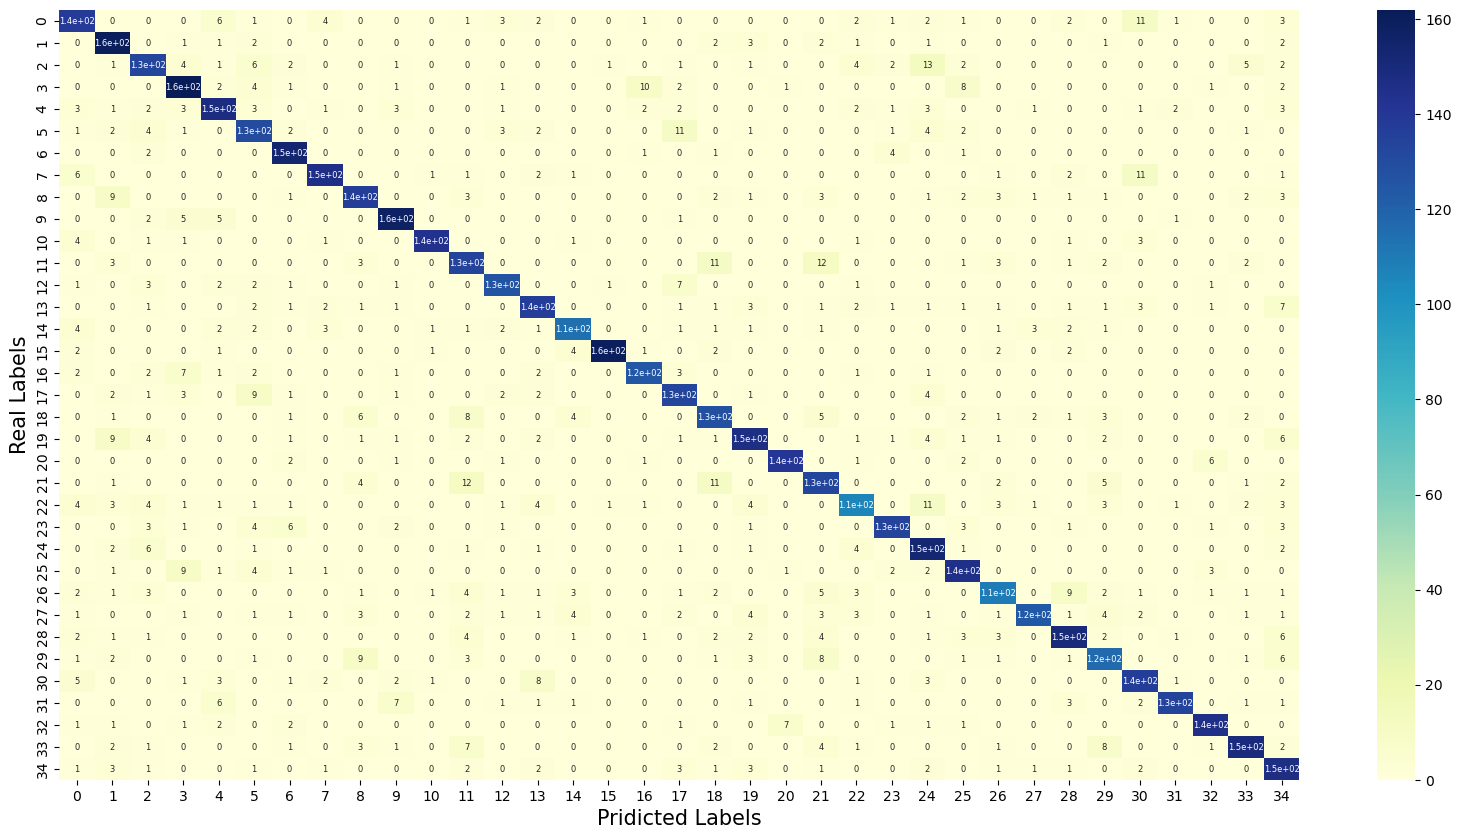

In [102]:
conf_matrix_plot(y_predict, y_test)

## check why 22 class has the lowest classification result

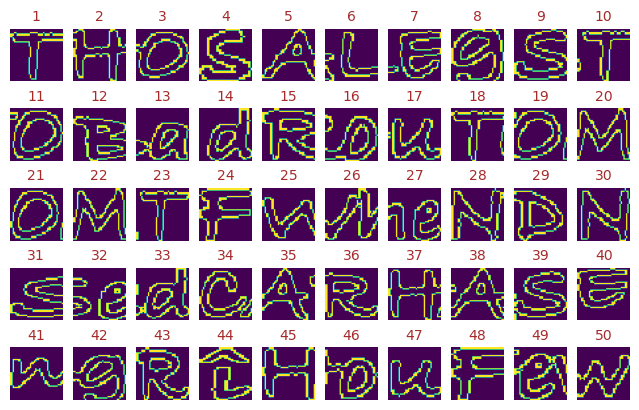

In [103]:
class_index = 22
label_index = label_resize.index(class_index)
img = img_resize[label_index:label_index+50]
for i in range(50):
    img_ = Image.open(img[i])
    plt.subplot(5, 10, i+1)
    plt.imshow(img_)
    plt.title(i+1, color='brown', fontsize=10)
    plt.axis('off')
plt.show()

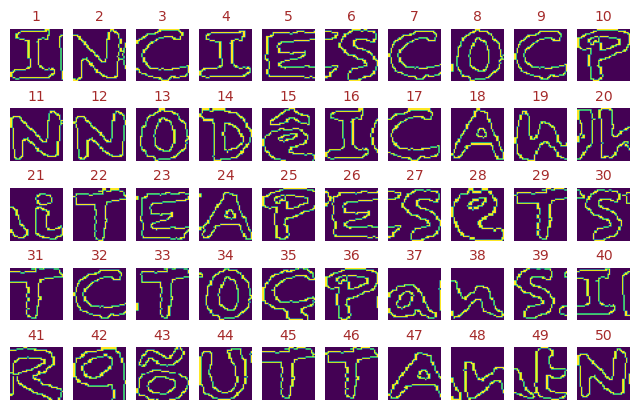

In [104]:
class_index = 24
label_index = label_resize.index(class_index)
img = img_resize[label_index:label_index+50]
for i in range(50):
    img_ = Image.open(img[i])
    plt.subplot(5, 10, i+1)
    plt.imshow(img_)
    plt.title(i+1, color='brown', fontsize=10)
    plt.axis('off')
plt.show()